In [1]:
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import math
import numpy as np
import imageio
import sklearn.cluster as skclust 

def load_all_fitnesses(filename,obj) :
    with open(filename) as file :
        csv_data = csv.reader(file,delimiter=',')
        best_fitnesses = []
        best_ind_id = []
        avg_fitnesses = []
        pop_size= []
        nb_eval = []
        nb_eval_tot = 0
        for row in csv_data :
            best_fitness = 0
            best_id = 0
            avg_fitness = 0
            nb_eval_tot += int(row[1])
            for i in range(3,len(row[:-1]),int(row[2])) :
                if(float(row[i+obj]) > best_fitness) :
                    best_fitness = float(row[i+obj])
                    best_id = int((i-3)/int(row[2]))
                    
                avg_fitness += float(row[i+obj])
            avg_fitness = avg_fitness/float(row[1])
            avg_fitnesses.append(avg_fitness)
            best_fitnesses.append(best_fitness)
            best_ind_id.append(best_id)
            nb_eval.append(nb_eval_tot)
            pop_size.append(int(row[1]))
            
    return nb_eval, best_ind_id, best_fitnesses, avg_fitnesses, pop_size

def load_score(filename) :
    with open(filename) as file :
        csv_data = csv.reader(file,delimiter=',')
        score = []
        nb_eval = []
        n_eval_tot = 0
        pop_size = []
        for row in csv_data :
            for i in range(2,len(row[:-1])) :
                n_eval_tot+=1
                score.append(float(row[i]))    
                nb_eval.append(n_eval_tot)
            pop_size.append(int(row[1]))
            
    return nb_eval, pop_size, score

def load_fitness_of_gen(filename,obj,gen) :
    with open(filename) as file :
        csv_data = csv.reader(file,delimiter=',')
        fitnesses = []
        for row in csv_data :
            if(int(row[0]) == 0) :
                for i in range(3,len(row[:-1]),int(row[2])) :
                     fitnesses.append(float(row[i+obj]))
                break
    return fitnesses

def load_robustness_score(filename) :
    with open(filename) as file :
        csv_data = csv.reader(file,delimiter=',')
        pop_size = [int(row[1]) for i,row in enumerate(csv_data) if i == 0]
        fitnesses = [[] for _ in range(pop_size[0])]
    with open(filename) as file :
        csv_data = csv.reader(file,delimiter=',')
        for row in csv_data :
            for i in range(3,len(row[:-1])) :
                fitnesses[i-3].append(float(row[i]))
    return fitnesses

def load_best_fit_mo(filename) :
    with open(filename) as file :
        csv_data = csv.reader(file,delimiter=',')
        best_fit1 = []
        best_fit2 = []
        pop_size= []
        nb_eval = []
        nb_eval_tot = 0
        for row in csv_data :
            best_fitness = [0,0]
            avg_fitness = 0
            nb_eval_tot += int(row[1])
            for i in range(3,len(row[:-1]),int(row[2])) :
                if(float(row[i]) > best_fitness[0]) :
                    best_fitness = [float(row[i]),float(row[i+1])]
                    
            best_fit1.append(best_fitness[0])
            best_fit2.append(best_fitness[1])
            nb_eval.append(nb_eval_tot)
            pop_size.append(float(row[1]))
            
    return nb_eval, best_fit1, best_fit2, pop_size


def histo_nbeval(nbeval,bins) :
    histo = [0 for b in bins]
    for nbe in nbeval :
        for i in range(0,len(bins)) :
            if(nbe < int(bins[i])) :
                histo[i] += 1
                break
    for i in range(0,len(histo)) :
        histo[i] = float(histo[i])/float(len(nbeval))*100
    return histo

def best_fit(fitnesses_vec,from_i) :
    best_fits = []
    for fits in fitnesses_vec :
        best_fits.append(max(fits[from_i:]))
    return best_fits

def load_eval_time(filename) :
    with open(filename) as file :
        csv_data = csv.reader(file,delimiter=',')
        durations = []
        eval_nb = []
        for row in csv_data :
            durations.append(float(row[1])*1e-9)
            eval_nb.append(int(row[0]))
    return eval_nb, durations

def load_all_fit_from_fpos(filename,target) :
    best_fitnesses = []
    avg_fitnesses = []
    pop_size= []
    nb_eval = []
    with open(filename) as file :
        csv_data = csv.reader(file,delimiter=',')
        nb_eval_tot = 0
        for row in csv_data :
            fitnesses = []
            nb_eval_tot+=len(row[2:])/4
            for i in range(2,int(len(row[2:])/4),4) :
                fitnesses.append(compute_reward([float(row[i+1]),float(row[i+2])],target))
            best_fitnesses.append(max(fitnesses))
            avg_fitnesses.append(np.mean(fitnesses))
            pop_size.append(len(row[2:])/4)
            nb_eval.append(nb_eval_tot)
    return nb_eval, best_fitnesses, avg_fitnesses, pop_size

def load_final_pos(filename,pop,gen) :
    with open(filename) as file :
        csv_data = csv.reader(file,delimiter=',')
        x = []
        y = []
        for row in csv_data :
            if(float(row[1]) == gen) :
                i = 0
                j = 2
                while(i < pop - 1):
                    if(j >= len(row) -1) :
                        break
                    if(float(row[j]) == i and float(row[j+1]) != i+1) :
                        x.append(float(row[j+1]))
                        y.append(float(row[j+2]))
                        j+=3
                    
                    j+=1
                    i+=1
                break
        return x, y

    
def load_obs(filename) :
    with open(filename) as file :
        csv_data = csv.reader(file,delimiter=',')
        x = []
        y = []
        for row in csv_data :
            x.append(float(row[2]))
            y.append(float(row[3]))
    return x, y
    
def compute_reward(final_pos,target) :
    return 1 - math.sqrt((final_pos[0] - target[0])**2 + (final_pos[1] - target[1])**2)/math.sqrt(2**3)

def rewards(positions,target) :
    r = []
    for pos in positions :
        r.append(compute_reward(pos,target))
    return r

def animation_pop(foldername,pop_size,step) :
    plt.ioff()
    images = []
    for i in range(0,len(pop_size),step) :
        x_vec = []
        y_vec = []
        if(not os.path.isdir(foldername)) :
            continue
        x, y = load_final_pos(foldername + "/final_pos.csv",pop_size[i],i)
        x_vec = x_vec + x
        y_vec = y_vec + y   
                
        fig2, ax2 = plt.subplots(figsize=[10,10])
        ax2.set_ylim(-1.,1.)
        ax2.set_xlim(-1.,1.)
        plt.title("Generation " + str(i))
        plt.plot(x_vec,y_vec,'o')
        plt.savefig(foldername + "/pop_" + str(i) + ".jpg")
        plt.close(fig2)
        images.append(imageio.imread(foldername + "/pop_" + str(i) + ".jpg"))
    imageio.mimwrite(foldername + "_pop_gen.gif",images)

def load_descriptor(filename,desc_size) :
    '''
    Load a list of descriptor from a file
    Trait descriptor: <width,depth,height,voxels,wheels,sensor,joint,caster>
    '''
    with open(filename) as file :
        print(filename)
        csv_data = csv.reader(file,delimiter=',')
        descriptors = []
        for row in csv_data :
            desc = []
            for i in range(desc_size) :
                desc.append(float(row[i+1]))
            descriptors.append(desc)
        return np.array(descriptors)
    
def read_parameters(filename):
    '''
    Read a parameter and return a dictionnary
    '''
    parameters = dict()
    with open(filename) as file :
        print(filename)
        csv_data = csv.reader(file,delimiter=',')
        for row in csv_data:
            parameters[row[0]] = row[2]
    return parameters

def load_trajectory(filename):
    traj = []
    with open(filename) as file :
        csv_data = csv.reader(file,delimiter=';')
        t = 0
        for row in csv_data:
            position = row[0].split(',')
            pos = [float(elt) for elt in position]
            traj.append([t] + pos)
            t+=1
    return traj


[(0, 7, 0.187845), (1, 0, 0.198895), (2, 1, 0.19337), (3, 3, 0.110497), (4, 6, 0.198895), (5, 4, 0.121547), (6, 2, 0.132597), (7, 4, 0.18232), (8, 3, 0.154696), (9, 3, 0.259669), (10, 5, 0.19337), (11, 3, 0.171271), (12, 7, 0.121547), (13, 1, 0.165746), (14, 1, 0.270718), (15, 5, 0.303867), (16, 3, 0.353591), (17, 0, 0.0939227), (18, 8, 0.392265), (19, 7, 0.248619), (20, 1, 0.348066), (21, 2, 0.254144), (22, 4, 0.220994), (23, 4, 0.171271), (24, 1, 0.270718), (25, 0, 0.276243), (26, 6, 0.243094), (27, 5, 0.243094), (28, 5, 0.314917), (29, 1, 0.292818), (30, 6, 0.375691), (31, 5, 0.265193), (32, 6, 0.325967), (33, 1, 0.187845), (34, 6, 0.248619), (35, 9, 0.165746), (36, 9, 0.116022), (37, 4, 0.254144), (38, 1, 0.171271), (39, 9, 0.110497), (40, 8, 0.154696), (41, 3, 0.232044), (42, 6, 0.160221), (43, 8, 0.270718), (44, 0, 0.281768), (45, 3, 0.265193), (46, 4, 0.276243), (47, 8, 0.254144), (48, 7, 0.359116), (49, 0, 0.392265), (50, 3, 0.259669), (51, 8, 0.381215), (52, 6, 0.337017), (53,

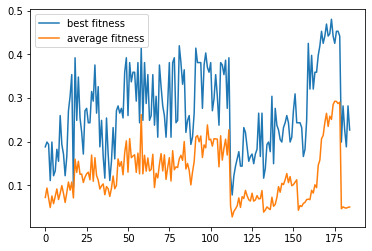

In [24]:
exp_folder = "/home/le_goff/are-logs/nipes_pretraining/exploration/177/nipes_13_8_17-25-52-2915-2631521776/"
neval, best_id, best_fit, avg_fit,pop_size = load_all_fitnesses(exp_folder + "/fitnesses.csv",0)
gen = range(len(best_fit))
fit_id = [(g,i,fit) for g,i,fit in zip(gen,best_id,best_fit)]

print(fit_id)

plt.plot(gen,best_fit,avg_fit)
plt.legend(["best fitness","average fitness","number of eval"])
plt.show()

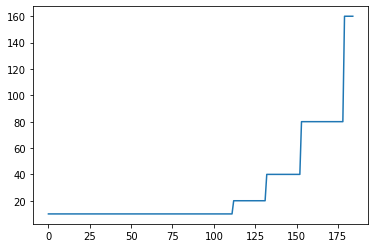

In [23]:
plt.plot(gen,pop_size)

[(0, 4, 0.0883978), (1, 5, 0.0883978), (2, 2, 0.226519), (3, 6, 0.104972), (4, 5, 0.149171), (5, 3, 0.154696), (6, 9, 0.121547), (7, 1, 0.127072), (8, 5, 0.160221), (9, 4, 0.243094), (10, 1, 0.138122), (11, 7, 0.287293), (12, 3, 0.138122), (13, 3, 0.21547), (14, 9, 0.243094), (15, 1, 0.259669), (16, 5, 0.303867), (17, 8, 0.303867), (18, 4, 0.259669), (19, 9, 0.276243), (20, 3, 0.392265), (21, 9, 0.287293), (22, 4, 0.331492), (23, 8, 0.292818), (24, 2, 0.298343), (25, 3, 0.320442), (26, 6, 0.403315), (27, 7, 0.502762), (28, 7, 0.364641), (29, 6, 0.309392), (30, 0, 0.276243), (31, 9, 0.220994), (32, 3, 0.348066), (33, 6, 0.292818), (34, 7, 0.281768), (35, 3, 0.453039), (36, 7, 0.348066), (37, 4, 0.38674), (38, 5, 0.375691), (39, 6, 0.436464), (40, 3, 0.309392), (41, 4, 0.370166), (42, 9, 0.309392), (43, 3, 0.41989), (44, 3, 0.453039), (45, 8, 0.403315), (46, 7, 0.469613), (47, 8, 0.370166), (48, 6, 0.287293), (49, 2, 0.453039), (50, 9, 0.364641), (51, 8, 0.243094), (52, 3, 0.546961), (53

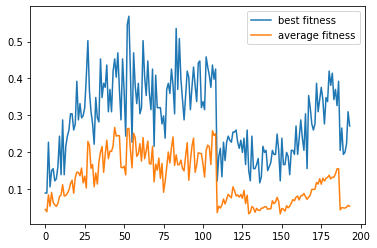

In [2]:
exp_folder = "/home/le_goff/are-logs/nipes_pretraining/exploration/177/nipes_20_8_15-29-47-7599-3006539628/"
neval, best_id, best_fit, avg_fit,pop_size = load_all_fitnesses(exp_folder + "/fitnesses.csv",0)
gen = range(len(best_fit))
fit_id = [(g,i,fit) for g,i,fit in zip(gen,best_id,best_fit)]

print(fit_id)

plt.plot(gen,best_fit,avg_fit)
plt.legend(["best fitness","average fitness","number of eval"])
plt.show()

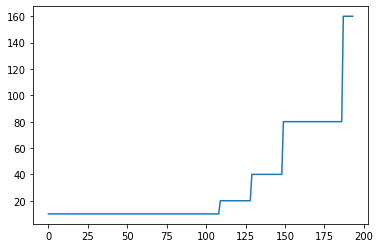

In [3]:
plt.plot(gen,pop_size)

[(0, 1, 0.254144), (1, 3, 0.19337), (2, 6, 0.154696), (3, 9, 0.149171), (4, 9, 0.0939227), (5, 8, 0.0939227), (6, 4, 0.20442), (7, 5, 0.0994475), (8, 3, 0.104972), (9, 3, 0.132597), (10, 5, 0.254144), (11, 6, 0.165746), (12, 7, 0.198895), (13, 2, 0.116022), (14, 5, 0.165746), (15, 2, 0.154696), (16, 6, 0.104972), (17, 9, 0.248619), (18, 1, 0.281768), (19, 5, 0.143646), (20, 2, 0.116022), (21, 5, 0.154696), (22, 6, 0.337017), (23, 4, 0.309392), (24, 8, 0.337017), (25, 6, 0.232044), (26, 9, 0.116022), (27, 4, 0.160221), (28, 4, 0.138122), (29, 9, 0.243094), (30, 6, 0.20442), (31, 5, 0.209945), (32, 5, 0.232044), (33, 5, 0.176796), (34, 6, 0.254144), (35, 8, 0.171271), (36, 0, 0.20442), (37, 6, 0.276243), (38, 9, 0.270718), (39, 5, 0.198895), (40, 2, 0.19337), (41, 8, 0.265193), (42, 6, 0.298343), (43, 3, 0.270718), (44, 4, 0.232044), (45, 14, 0.187845), (46, 9, 0.243094), (47, 5, 0.110497), (48, 12, 0.116022), (49, 4, 0.143646), (50, 8, 0.176796), (51, 7, 0.524862), (52, 5, 0.243094), (5

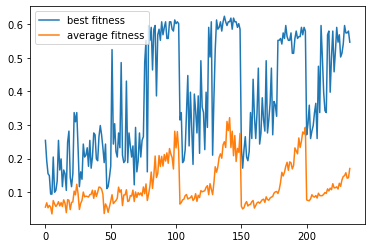

In [9]:
exp_folder = "/home/leni/are-logs/nipes_pretraining/exploration/191/nipes_14_8_10-47-43-3383-1049039334/"
neval, best_id, best_fit, avg_fit,pop_size = load_all_fitnesses(exp_folder + "/fitnesses.csv",0)
gen = range(len(best_fit))
fit_id = [(g,i,fit) for g,i,fit in zip(gen,best_id,best_fit)]
exp_folder = "/home/leni/are-logs/nipes_pretraining/exploration/191/nipes_14_8_14-57-56-6050-3172684440/"
neval2, best_id2, best_fit2, avg_fit2,pop_size2 = load_all_fitnesses(exp_folder + "/fitnesses.csv",0)
gen2 = range(len(best_fit2))
fit_id2 = [(g,i,fit) for g,i,fit in zip(gen2,best_id2,best_fit2)]

best_fit += best_fit2
avg_fit += avg_fit2
best_id += best_id2
pop_size += pop_size2
gen = range(len(best_fit))
print(fit_id)
print(fit_id2)
plt.plot(gen,best_fit,avg_fit)
plt.legend(["best fitness","average fitness","number of eval"])
plt.show()

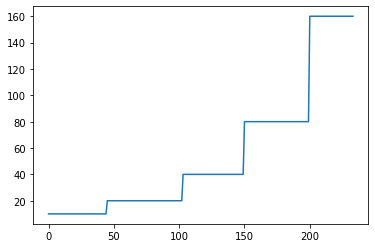

In [7]:
plt.plot(gen,pop_size)

[(0, 8, 0.64132), (1, 3, 0.613276), (2, 4, 0.727808), (3, 9, 0.561038), (4, 8, 0.599379), (5, 4, 0.863995), (6, 8, 0.749044), (7, 4, 0.865914), (8, 0, 0.643141), (9, 0, 0.903099), (10, 3, 0.745156), (11, 5, 0.913267), (12, 3, 0.887387), (13, 1, 0.836868), (14, 6, 0.87556), (15, 9, 0.791852), (16, 4, 0.940988), (17, 2, 0.560474), (18, 6, 0.858048), (19, 6, 0.819534), (20, 8, 0.7342), (21, 7, 0.768804), (22, 5, 0.888461), (23, 4, 0.732514), (24, 3, 0.581088), (25, 3, 0.743158), (26, 6, 0.905018), (27, 4, 0.948975), (28, 2, 0.916587), (29, 2, 0.93899), (30, 6, 0.945066), (31, 0, 0.943168), (32, 6, 0.926578), (33, 8, 0.929152), (34, 8, 0.924173), (35, 1, 0.935915), (36, 2, 0.908501), (37, 4, 0.933659), (38, 0, 0.96248), (39, 9, 0.932208), (40, 7, 0.91727), (41, 9, 0.953318), (42, 8, 0.94641), (43, 9, 0.922057), (44, 6, 0.921716), (45, 17, 0.582727), (46, 16, 0.62123), (47, 2, 0.645801), (48, 0, 0.531917), (49, 5, 0.511794), (50, 10, 0.799497), (51, 10, 0.653739), (52, 11, 0.91835), (53, 18

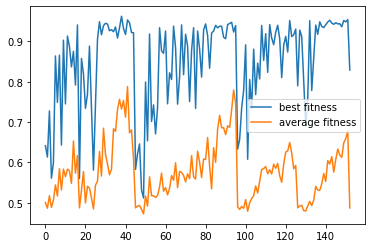

In [10]:
exp_folder = "/home/leni/are-logs/nipes_pretraining/corridor/69/nipes_15_8_10-59-28-8274-1492058421/"
neval, best_id, best_fit, avg_fit,pop_size = load_all_fitnesses(exp_folder + "/fitnesses.csv",0)
gen = range(len(best_fit))
fit_id = [(g,i,fit) for g,i,fit in zip(gen,best_id,best_fit)]

print(fit_id)
plt.plot(gen,best_fit,avg_fit)
plt.legend(["best fitness","average fitness","number of eval"])
plt.show()

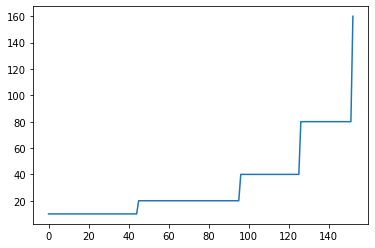

In [11]:
plt.plot(gen,pop_size)

[(0, 7, 0.677512), (1, 6, 0.668628), (2, 0, 0.594361), (3, 8, 0.572884), (4, 5, 0.620824), (5, 2, 0.623337), (6, 5, 0.634664), (7, 7, 0.639276), (8, 3, 0.788811), (9, 1, 0.621418), (10, 4, 0.8211), (11, 7, 0.594777), (12, 6, 0.597544), (13, 9, 0.655473), (14, 3, 0.672043), (15, 0, 0.568057), (16, 1, 0.530598), (17, 2, 0.582985), (18, 5, 0.62388), (19, 3, 0.613823), (20, 5, 0.668221), (21, 0, 0.607969), (22, 8, 0.717643), (23, 5, 0.785086), (24, 2, 0.720157), (25, 3, 0.666022), (26, 6, 0.554149), (27, 0, 0.658094), (28, 5, 0.702326), (29, 1, 0.660294), (30, 0, 0.641144), (31, 7, 0.655875), (32, 7, 0.782852), (33, 0, 0.634859), (34, 1, 0.566388), (35, 5, 0.588111), (36, 2, 0.634597), (37, 4, 0.642155), (38, 3, 0.645994), (39, 8, 0.648489), (40, 9, 0.649875), (41, 2, 0.624963), (42, 1, 0.630865), (43, 1, 0.651145), (44, 9, 0.625035), (45, 17, 0.695126), (46, 1, 0.652817), (47, 14, 0.762092), (48, 9, 0.831298), (49, 17, 0.648629), (50, 2, 0.732265), (51, 8, 0.684588), (52, 19, 0.685543), (

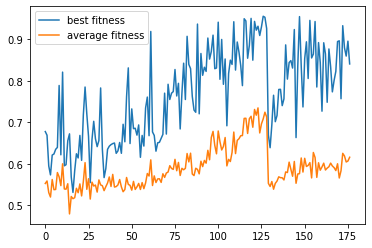

In [5]:
exp_folder = "/home/le_goff/are-logs/nipes_pretraining/corridor/56/nipes_16_8_10-45-23-3323-1234224863/"
neval, best_id, best_fit, avg_fit,pop_size = load_all_fitnesses(exp_folder + "/fitnesses.csv",0)
gen = range(len(best_fit))
fit_id = [(g,i,fit) for g,i,fit in zip(gen,best_id,best_fit)]

print(fit_id)
plt.plot(gen,best_fit,avg_fit)
plt.legend(["best fitness","average fitness","number of eval"])
plt.show()

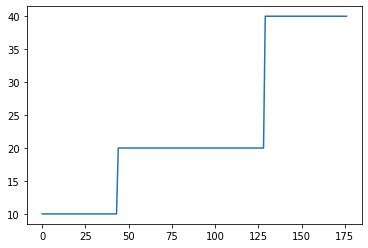

In [6]:
plt.plot(gen,pop_size)

[(0, 8, 0.0828729), (1, 7, 0.149171), (2, 6, 0.0883978), (3, 3, 0.0773481), (4, 9, 0.143646), (5, 1, 0.138122), (6, 4, 0.132597), (7, 4, 0.138122), (8, 7, 0.121547), (9, 7, 0.116022), (10, 3, 0.110497), (11, 4, 0.127072), (12, 1, 0.165746), (13, 3, 0.127072), (14, 3, 0.116022), (15, 3, 0.127072), (16, 1, 0.149171), (17, 9, 0.121547), (18, 1, 0.226519), (19, 1, 0.138122), (20, 11, 0.0994475), (21, 1, 0.121547), (22, 7, 0.149171), (23, 2, 0.132597), (24, 17, 0.132597), (25, 5, 0.127072), (26, 0, 0.160221), (27, 16, 0.259669), (28, 9, 0.176796), (29, 7, 0.171271), (30, 9, 0.154696), (31, 14, 0.149171), (32, 13, 0.20442), (33, 4, 0.226519), (34, 2, 0.19337), (35, 9, 0.209945), (36, 2, 0.149171), (37, 11, 0.160221), (38, 8, 0.176796), (39, 7, 0.187845), (40, 2, 0.110497), (41, 4, 0.121547), (42, 32, 0.18232), (43, 35, 0.21547), (44, 10, 0.171271), (45, 16, 0.116022), (46, 10, 0.220994), (47, 13, 0.165746), (48, 5, 0.209945), (49, 21, 0.176796), (50, 6, 0.198895), (51, 35, 0.209945), (52, 21

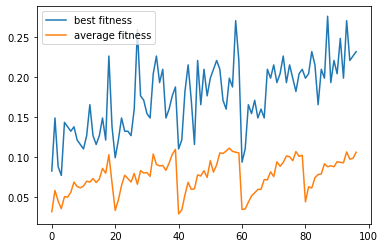

In [2]:
exp_folder = "/home/leni/are-logs/nipes_pretraining/exploration/142/nipes_21_8_16-57-55-5217-3660553826/"
neval, best_id, best_fit, avg_fit,pop_size = load_all_fitnesses(exp_folder + "/fitnesses.csv",0)
gen = range(len(best_fit))
fit_id = [(g,i,fit) for g,i,fit in zip(gen,best_id,best_fit)]

print(fit_id)
plt.plot(gen,best_fit,avg_fit)
plt.legend(["best fitness","average fitness","number of eval"])
plt.show()

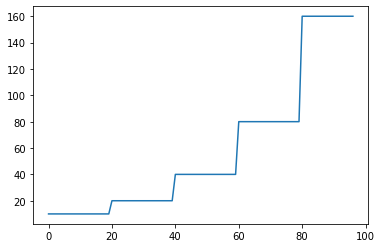

In [3]:
plt.plot(gen,pop_size)

[(0, 2, 0.116022), (1, 9, 0.0883978), (2, 2, 0.0939227), (3, 7, 0.143646), (4, 1, 0.0994475), (5, 0, 0.187845), (6, 9, 0.127072), (7, 0, 0.154696), (8, 5, 0.121547), (9, 6, 0.110497), (10, 0, 0.187845), (11, 4, 0.143646), (12, 5, 0.149171), (13, 1, 0.19337), (14, 6, 0.165746), (15, 3, 0.165746), (16, 3, 0.143646), (17, 7, 0.165746), (18, 4, 0.165746), (19, 6, 0.18232), (20, 11, 0.0662983), (21, 10, 0.121547), (22, 16, 0.0994475), (23, 19, 0.176796), (24, 1, 0.160221), (25, 9, 0.209945), (26, 11, 0.198895), (27, 11, 0.143646), (28, 7, 0.232044), (29, 1, 0.154696), (30, 0, 0.165746), (31, 5, 0.18232), (32, 15, 0.198895), (33, 12, 0.198895), (34, 6, 0.187845), (35, 8, 0.154696), (36, 13, 0.171271), (37, 1, 0.176796), (38, 12, 0.21547), (39, 16, 0.176796), (40, 38, 0.116022), (41, 0, 0.143646), (42, 10, 0.18232), (43, 33, 0.18232), (44, 23, 0.232044), (45, 9, 0.127072), (46, 36, 0.220994), (47, 3, 0.21547), (48, 24, 0.270718), (49, 17, 0.237569), (50, 18, 0.248619), (51, 20, 0.209945), (52

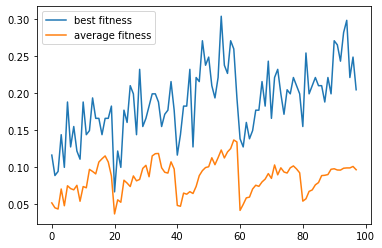

In [4]:
exp_folder = "/home/leni/are-logs/nipes_pretraining/exploration/9_184/nipes_21_8_11-18-41-1718-1638057784/"
neval, best_id, best_fit, avg_fit,pop_size = load_all_fitnesses(exp_folder + "/fitnesses.csv",0)
gen = range(len(best_fit))
fit_id = [(g,i,fit) for g,i,fit in zip(gen,best_id,best_fit)]

print(fit_id)
plt.plot(gen,best_fit,avg_fit)
plt.legend(["best fitness","average fitness","number of eval"])
plt.show()

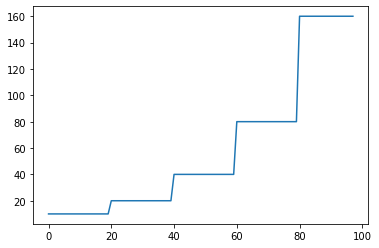

In [5]:
plt.plot(gen,pop_size)

[(0, 7, 0.265193), (1, 8, 0.138122), (2, 6, 0.198895), (3, 3, 0.18232), (4, 4, 0.276243), (5, 6, 0.270718), (6, 4, 0.254144), (7, 5, 0.243094), (8, 9, 0.276243), (9, 5, 0.209945), (10, 1, 0.237569), (11, 5, 0.19337), (12, 0, 0.276243), (13, 0, 0.265193), (14, 0, 0.248619), (15, 3, 0.220994), (16, 0, 0.259669), (17, 2, 0.226519), (18, 4, 0.337017), (19, 4, 0.18232), (20, 4, 0.248619), (21, 12, 0.19337), (22, 12, 0.19337), (23, 4, 0.254144), (24, 2, 0.160221), (25, 14, 0.19337), (26, 0, 0.143646), (27, 1, 0.265193), (28, 13, 0.165746), (29, 15, 0.165746), (30, 17, 0.276243), (31, 3, 0.281768), (32, 0, 0.331492), (33, 11, 0.381215), (34, 19, 0.320442), (35, 5, 0.320442), (36, 13, 0.298343), (37, 11, 0.287293), (38, 11, 0.353591), (39, 0, 0.39779), (40, 4, 0.364641), (41, 19, 0.381215), (42, 7, 0.370166), (43, 19, 0.40884), (44, 1, 0.39779), (45, 5, 0.359116), (46, 10, 0.39779), (47, 0, 0.375691), (48, 13, 0.348066), (49, 1, 0.480663), (50, 1, 0.430939), (51, 3, 0.298343), (52, 30, 0.23756

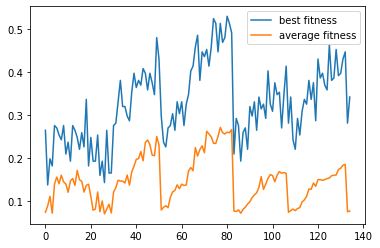

In [2]:
exp_folder = "/home/leni/are-logs/nipes_pretraining/exploration/1_184/nipes_21_8_10-21-51-1541-3010644679/"
neval, best_id, best_fit, avg_fit,pop_size = load_all_fitnesses(exp_folder + "/fitnesses.csv",0)
gen = range(len(best_fit))
fit_id = [(g,i,fit) for g,i,fit in zip(gen,best_id,best_fit)]

print(fit_id)
plt.plot(gen,best_fit,avg_fit)
plt.legend(["best fitness","average fitness","number of eval"])
plt.show()

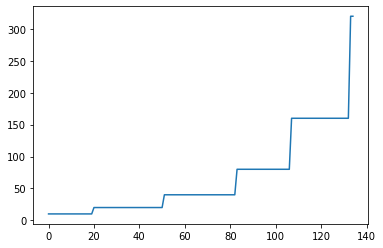

In [3]:
plt.plot(gen,pop_size)

[(0, 4, 0.138122), (1, 7, 0.20442), (2, 7, 0.116022), (3, 8, 0.220994), (4, 9, 0.281768), (5, 6, 0.254144), (6, 3, 0.381215), (7, 7, 0.281768), (8, 7, 0.370166), (9, 8, 0.342541), (10, 8, 0.414365), (11, 2, 0.320442), (12, 7, 0.364641), (13, 6, 0.39779), (14, 0, 0.342541), (15, 5, 0.337017), (16, 0, 0.403315), (17, 2, 0.392265), (18, 2, 0.325967), (19, 8, 0.359116), (20, 2, 0.414365), (21, 8, 0.364641), (22, 1, 0.359116), (23, 3, 0.425414), (24, 17, 0.171271), (25, 16, 0.337017), (26, 15, 0.381215), (27, 12, 0.342541), (28, 14, 0.320442), (29, 4, 0.287293), (30, 0, 0.303867), (31, 14, 0.392265), (32, 5, 0.342541), (33, 7, 0.447514), (34, 1, 0.458564), (35, 2, 0.370166), (36, 6, 0.331492), (37, 14, 0.375691), (38, 8, 0.348066), (39, 12, 0.381215), (40, 9, 0.38674), (41, 0, 0.40884), (42, 19, 0.364641), (43, 8, 0.41989), (44, 8, 0.41989), (45, 39, 0.320442), (46, 21, 0.325967), (47, 19, 0.414365), (48, 17, 0.325967), (49, 27, 0.237569), (50, 9, 0.298343), (51, 0, 0.337017), (52, 38, 0.22

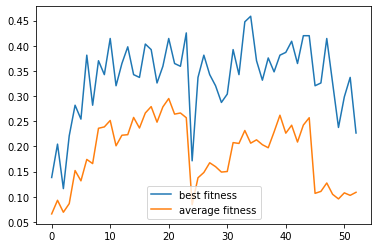

In [4]:
exp_folder = "/home/le_goff/are-logs/nipes_pretraining/exploration/410/nipes_5_9_14-45-43-3782-55509151/"
neval, best_id, best_fit, avg_fit,pop_size = load_all_fitnesses(exp_folder + "/fitnesses.csv",0)
gen = range(len(best_fit))
fit_id = [(g,i,fit) for g,i,fit in zip(gen,best_id,best_fit)]

print(fit_id)
plt.plot(gen,best_fit,avg_fit)
plt.legend(["best fitness","average fitness","number of eval"])
plt.show()

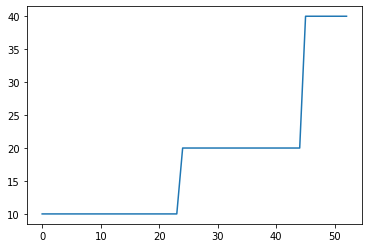

In [5]:
plt.plot(gen,pop_size)

[(0, 9, 0.220994), (1, 8, 0.331492), (2, 1, 0.232044), (3, 5, 0.149171), (4, 7, 0.40884), (5, 2, 0.392265), (6, 5, 0.41989), (7, 8, 0.348066), (8, 1, 0.325967), (9, 9, 0.370166), (10, 1, 0.453039), (11, 3, 0.303867), (12, 3, 0.298343), (13, 0, 0.348066), (14, 6, 0.403315), (15, 8, 0.320442), (16, 0, 0.331492), (17, 6, 0.469613), (18, 7, 0.303867), (19, 8, 0.325967), (20, 6, 0.375691), (21, 3, 0.414365), (22, 1, 0.381215), (23, 1, 0.425414), (24, 5, 0.353591), (25, 7, 0.414365), (26, 4, 0.359116), (27, 4, 0.41989), (28, 0, 0.375691), (29, 5, 0.38674), (30, 6, 0.292818), (31, 8, 0.364641), (32, 4, 0.39779), (33, 5, 0.414365), (34, 2, 0.392265), (35, 4, 0.381215), (36, 6, 0.353591), (37, 3, 0.370166), (38, 8, 0.392265), (39, 2, 0.436464), (40, 3, 0.375691), (41, 4, 0.40884), (42, 3, 0.436464), (43, 7, 0.38674), (44, 2, 0.40884), (45, 5, 0.38674), (46, 6, 0.447514), (47, 9, 0.436464), (48, 8, 0.425414), (49, 1, 0.392265), (50, 0, 0.436464), (51, 3, 0.40884), (52, 8, 0.447514), (53, 4, 0.40

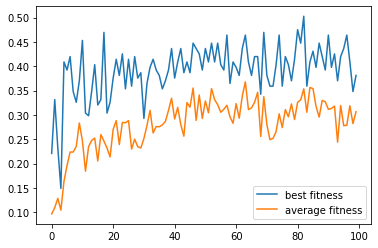

In [6]:
exp_folder = "/home/le_goff/are-logs/nipes_pretraining/exploration/410/nipes_5_9_14-46-5-5309-2449853080/"
neval, best_id, best_fit, avg_fit,pop_size = load_all_fitnesses(exp_folder + "/fitnesses.csv",0)
gen = range(len(best_fit))
fit_id = [(g,i,fit) for g,i,fit in zip(gen,best_id,best_fit)]

print(fit_id)
plt.plot(gen,best_fit,avg_fit)
plt.legend(["best fitness","average fitness","number of eval"])
plt.show()

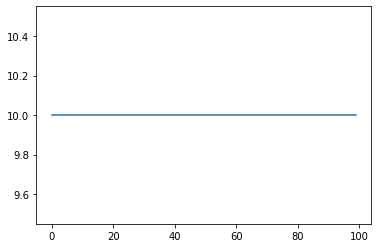

In [7]:
plt.plot(gen,pop_size)

[(0, 2, 0.132597), (1, 6, 0.160221), (2, 2, 0.127072), (3, 3, 0.18232), (4, 1, 0.198895), (5, 5, 0.110497), (6, 4, 0.149171), (7, 3, 0.198895), (8, 9, 0.19337), (9, 7, 0.138122), (10, 7, 0.160221), (11, 7, 0.353591), (12, 0, 0.18232), (13, 2, 0.110497), (14, 7, 0.138122), (15, 4, 0.198895), (16, 4, 0.226519), (17, 9, 0.187845), (18, 0, 0.320442), (19, 4, 0.132597), (20, 5, 0.116022), (21, 4, 0.287293), (22, 5, 0.337017), (23, 2, 0.320442), (24, 4, 0.309392), (25, 9, 0.403315), (26, 9, 0.226519), (27, 9, 0.276243), (28, 5, 0.325967), (29, 8, 0.298343), (30, 7, 0.281768), (31, 3, 0.370166), (32, 7, 0.287293), (33, 4, 0.232044), (34, 4, 0.254144), (35, 6, 0.353591), (36, 4, 0.309392), (37, 3, 0.281768), (38, 7, 0.337017), (39, 0, 0.287293), (40, 3, 0.265193), (41, 1, 0.276243), (42, 3, 0.375691), (43, 6, 0.309392), (44, 7, 0.392265), (45, 4, 0.309392), (46, 6, 0.464088), (47, 1, 0.287293), (48, 7, 0.20442), (49, 2, 0.259669), (50, 4, 0.342541), (51, 9, 0.259669), (52, 1, 0.259669), (53, 9

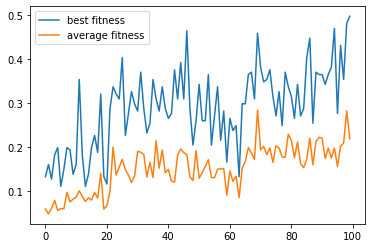

In [6]:
exp_folder = "/home/leni/are-logs/nipes_pretraining/exploration/166/nipes_4_9_14-30-59-9872-1606771321/"
neval, best_id, best_fit, avg_fit,pop_size = load_all_fitnesses(exp_folder + "/fitnesses.csv",0)
gen = range(len(best_fit))
fit_id = [(g,i,fit) for g,i,fit in zip(gen,best_id,best_fit)]

print(fit_id)
plt.plot(gen,best_fit,avg_fit)
plt.legend(["best fitness","average fitness","number of eval"])
plt.show()

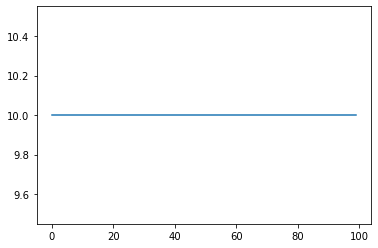

In [7]:
plt.plot(gen,pop_size)

[(0, 6, 0.110497), (1, 2, 0.143646), (2, 7, 0.259669), (3, 9, 0.237569), (4, 1, 0.0994475), (5, 4, 0.127072), (6, 9, 0.132597), (7, 6, 0.314917), (8, 0, 0.165746), (9, 9, 0.220994), (10, 9, 0.143646), (11, 7, 0.20442), (12, 1, 0.220994), (13, 3, 0.21547), (14, 1, 0.198895), (15, 9, 0.259669), (16, 7, 0.237569), (17, 7, 0.19337), (18, 8, 0.314917), (19, 4, 0.220994), (20, 1, 0.209945), (21, 8, 0.127072), (22, 0, 0.303867), (23, 3, 0.149171), (24, 3, 0.198895), (25, 6, 0.292818), (26, 0, 0.19337), (27, 4, 0.187845), (28, 5, 0.127072), (29, 3, 0.20442), (30, 6, 0.19337), (31, 7, 0.226519), (32, 4, 0.18232), (33, 1, 0.19337), (34, 8, 0.254144), (35, 9, 0.303867), (36, 6, 0.198895), (37, 0, 0.303867), (38, 1, 0.165746), (39, 5, 0.154696), (40, 8, 0.171271), (41, 5, 0.259669), (42, 7, 0.198895), (43, 2, 0.171271), (44, 6, 0.237569), (45, 3, 0.198895), (46, 19, 0.18232), (47, 4, 0.132597), (48, 16, 0.226519), (49, 0, 0.160221), (50, 4, 0.226519), (51, 1, 0.292818), (52, 16, 0.143646), (53, 3,

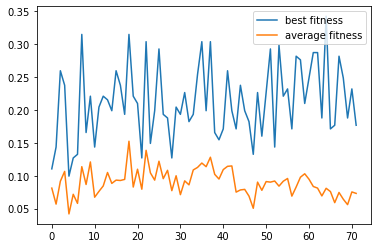

In [8]:
exp_folder = "/home/leni/are-logs/nipes_pretraining/166/"
neval, best_id, best_fit, avg_fit,pop_size = load_all_fitnesses(exp_folder + "/fitnesses.csv",0)
gen = range(len(best_fit))
fit_id = [(g,i,fit) for g,i,fit in zip(gen,best_id,best_fit)]

print(fit_id)
plt.plot(gen,best_fit,avg_fit)
plt.legend(["best fitness","average fitness","number of eval"])
plt.show()

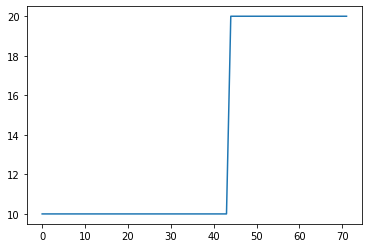

In [9]:
plt.plot(gen,pop_size)

[(0, 6, 0.154696), (1, 1, 0.176796), (2, 5, 0.18232), (3, 4, 0.154696), (4, 8, 0.165746), (5, 5, 0.281768), (6, 8, 0.171271), (7, 2, 0.198895), (8, 9, 0.20442), (9, 9, 0.132597), (10, 2, 0.121547), (11, 8, 0.18232), (12, 2, 0.149171), (13, 2, 0.127072), (14, 4, 0.154696), (15, 1, 0.209945), (16, 9, 0.176796), (17, 1, 0.18232), (18, 1, 0.248619), (19, 7, 0.187845), (20, 7, 0.171271), (21, 0, 0.171271), (22, 0, 0.160221), (23, 2, 0.254144), (24, 4, 0.198895), (25, 4, 0.160221), (26, 5, 0.176796), (27, 0, 0.165746), (28, 7, 0.248619), (29, 1, 0.237569), (30, 5, 0.226519), (31, 6, 0.254144), (32, 6, 0.292818), (33, 2, 0.292818), (34, 9, 0.226519), (35, 2, 0.270718), (36, 6, 0.287293), (37, 3, 0.337017), (38, 6, 0.265193), (39, 0, 0.303867), (40, 4, 0.270718), (41, 2, 0.254144), (42, 1, 0.232044), (43, 6, 0.292818), (44, 2, 0.309392), (45, 1, 0.287293), (46, 7, 0.265193), (47, 1, 0.337017), (48, 1, 0.20442), (49, 9, 0.259669), (50, 7, 0.226519), (51, 3, 0.220994), (52, 9, 0.21547), (53, 4, 

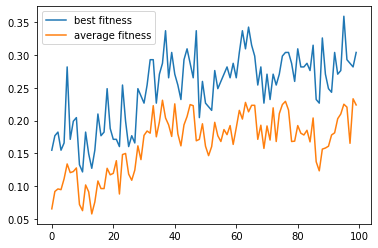

In [10]:
exp_folder = "/home/leni/are-logs/nipes_pretraining/exploration/130/nipes_4_9_14-35-56-6247-4095308178/"
neval, best_id, best_fit, avg_fit,pop_size = load_all_fitnesses(exp_folder + "/fitnesses.csv",0)
gen = range(len(best_fit))
fit_id = [(g,i,fit) for g,i,fit in zip(gen,best_id,best_fit)]

print(fit_id)
plt.plot(gen,best_fit,avg_fit)
plt.legend(["best fitness","average fitness","number of eval"])
plt.show()

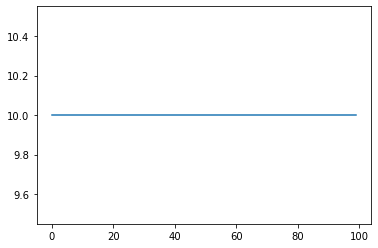

In [11]:
plt.plot(gen,pop_size)

[(0, 2, 0.0607735), (1, 2, 0.116022), (2, 3, 0.127072), (3, 6, 0.127072), (4, 6, 0.121547), (5, 3, 0.226519), (6, 4, 0.154696), (7, 1, 0.19337), (8, 6, 0.154696), (9, 4, 0.209945), (10, 7, 0.160221), (11, 2, 0.198895), (12, 5, 0.292818), (13, 4, 0.270718), (14, 1, 0.298343), (15, 0, 0.259669), (16, 0, 0.248619), (17, 1, 0.254144), (18, 0, 0.348066), (19, 8, 0.281768), (20, 6, 0.287293), (21, 9, 0.292818), (22, 2, 0.287293), (23, 9, 0.309392), (24, 2, 0.287293), (25, 5, 0.265193), (26, 8, 0.287293), (27, 8, 0.331492), (28, 2, 0.254144), (29, 2, 0.110497), (30, 18, 0.176796), (31, 14, 0.165746), (32, 13, 0.160221), (33, 16, 0.19337), (34, 0, 0.132597), (35, 5, 0.19337), (36, 0, 0.220994), (37, 0, 0.176796), (38, 11, 0.19337), (39, 3, 0.20442), (40, 16, 0.19337), (41, 3, 0.220994), (42, 2, 0.160221), (43, 9, 0.270718), (44, 0, 0.331492), (45, 19, 0.209945), (46, 19, 0.254144), (47, 1, 0.248619), (48, 18, 0.270718), (49, 9, 0.270718), (50, 2, 0.226519), (51, 3, 0.276243), (52, 13, 0.19337)

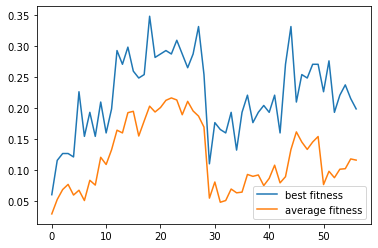

In [12]:
exp_folder = "/home/leni/are-logs/nipes_pretraining/130/"
neval, best_id, best_fit, avg_fit,pop_size = load_all_fitnesses(exp_folder + "/fitnesses.csv",0)
gen = range(len(best_fit))
fit_id = [(g,i,fit) for g,i,fit in zip(gen,best_id,best_fit)]

print(fit_id)
plt.plot(gen,best_fit,avg_fit)
plt.legend(["best fitness","average fitness","number of eval"])
plt.show()

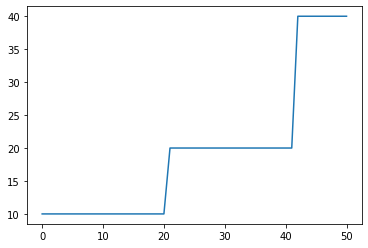

In [5]:
plt.plot(gen,pop_size)

0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
[(0, 0, 0.254144), (1, 3, 0.19337), (2, 3, 0.248619), (3, 2, 0.20442), (4, 2, 0.19337), (5, 4, 0.40884), (6, 2, 0.254144), (7, 0, 0.127072), (8, 1, 0.127072), (9, 2, 0.0994475), (10, 0, 0.110497), (11, 4, 0.116022), (12, 3, 0.149171), (13, 1, 0.209945), (14, 1, 0.165746), (15, 0, 0.138122), (16, 0, 0.198895), (17, 3, 0.154696), (18, 1, 0.116022), (19, 0, 0.21547)]


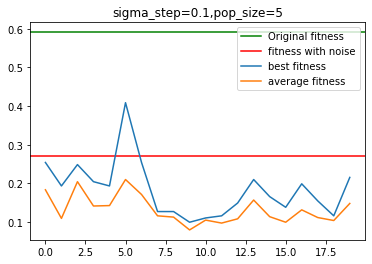

In [115]:
#CMAES_step=0.1
#pop_size=5
exp_folder = "/home/leni/are-logs/nipes_pretraining/exploration/191/relearning/nipes_23_8_11-58-51-1942-1386119153/"
neval, best_id, best_fit, avg_fit,pop_size = load_all_fitnesses(exp_folder + "/fitnesses.csv",0)
gen = range(len(best_fit))
fit_id = [(g,i,fit) for g,i,fit in zip(gen,best_id,best_fit)]

print(fit_id)
plt.axhline(y=0.59116, color='g', linestyle='-')
plt.axhline(y=0.270718, color='r', linestyle='-')
plt.plot(gen,best_fit,avg_fit)
plt.legend(["Original fitness", "fitness with noise", "best fitness","average fitness"])
plt.title("sigma_step=0.1,pop_size=5")
plt.show()

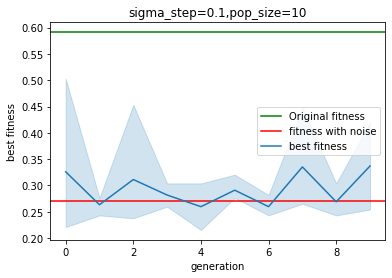

In [28]:
#CMAES_step=0.1
#pop_size=10
exp_folder = "/home/le_goff/are-logs/nipes_pretraining/exploration/191/relearning/s01_p10"
lines = []
for folder in os.listdir(exp_folder):
    neval, best_id, best_fit, avg_fit,pop_size = load_all_fitnesses(exp_folder + "/" + folder + "/fitnesses.csv",0)
    gen = range(len(best_fit))
    lines += [[g,bf,af] for g,bf,af in zip(gen,best_fit,avg_fit)] 
    
data = pd.DataFrame(data=lines,columns=["generation","best fitness","average fitness"])
plt.axhline(y=0.59116, color='g', linestyle='-')
plt.axhline(y=0.270718, color='r', linestyle='-')
sns.lineplot(data=data,x="generation",y="best fitness")
plt.legend(["Original fitness", "fitness with noise", "best fitness"])
plt.title("sigma_step=0.1,pop_size=10")
plt.show()

In [42]:
#CMAES_step=0.1
#pop_size=100
exp_folder = "/home/leni/are-logs/nipes_pretraining/exploration/191/relearning/s01_p10_n0/"
lines = []
for folder in os.listdir(exp_folder):
    neval, best_id, best_fit, avg_fit,pop_size = load_all_fitnesses(exp_folder + "/" + folder + "/fitnesses.csv",0)
    gen = range(len(best_fit))
    lines += [[g,bf,af,"0"] for g,bf,af in zip(gen,best_fit,avg_fit)] 
    

In [43]:
#CMAES_step=0.1
#pop_size=100
exp_folder = "/home/leni/are-logs/nipes_pretraining/exploration/191/relearning/s01_p10_n05/"
for folder in os.listdir(exp_folder):
    neval, best_id, best_fit, avg_fit,pop_size = load_all_fitnesses(exp_folder + "/" + folder + "/fitnesses.csv",0)
    gen = range(len(best_fit))
    lines += [[g,bf,af,"0.5"] for g,bf,af in zip(gen,best_fit,avg_fit)] 
    

In [44]:
#CMAES_step=0.1
#pop_size=100
exp_folder = "/home/leni/are-logs/nipes_pretraining/exploration/191/relearning/s01_p10_n1/"
for folder in os.listdir(exp_folder):
    neval, best_id, best_fit, avg_fit,pop_size = load_all_fitnesses(exp_folder + "/" + folder + "/fitnesses.csv",0)
    gen = range(len(best_fit))
    lines += [[g,bf,af,"1."] for g,bf,af in zip(gen,best_fit,avg_fit)] 
    

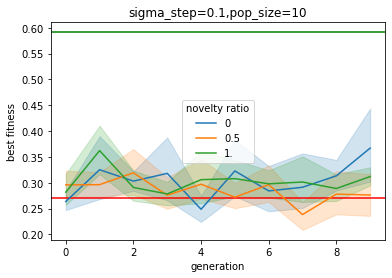

In [45]:
data = pd.DataFrame(data=lines,columns=["generation","best fitness","average fitness","novelty ratio"])
plt.axhline(y=0.59116, color='g', linestyle='-')
plt.axhline(y=0.270718, color='r', linestyle='-')
sns.lineplot(data=data,x="generation",y="best fitness",hue="novelty ratio")
# plt.legend(["Original fitness", "fitness with noise", "best fitness"])
plt.title("sigma_step=0.1,pop_size=10")
plt.show()

In [46]:
#CMAES_step=0.1
#pop_size=100
exp_folder = "/home/leni/are-logs/nipes_pretraining/exploration/191/relearning/s01_p20_n0/"
lines = []
for folder in os.listdir(exp_folder):
    neval, best_id, best_fit, avg_fit,pop_size = load_all_fitnesses(exp_folder + "/" + folder + "/fitnesses.csv",0)
    gen = range(len(best_fit))
    lines += [[g,bf,af,"0"] for g,bf,af in zip(gen,best_fit,avg_fit)] 
    

In [47]:
#CMAES_step=0.1
#pop_size=100
exp_folder = "/home/leni/are-logs/nipes_pretraining/exploration/191/relearning/s01_p20_n05/"
for folder in os.listdir(exp_folder):
    neval, best_id, best_fit, avg_fit,pop_size = load_all_fitnesses(exp_folder + "/" + folder + "/fitnesses.csv",0)
    gen = range(len(best_fit))
    lines += [[g,bf,af,"0.5"] for g,bf,af in zip(gen,best_fit,avg_fit)] 
    

In [48]:
#CMAES_step=0.1
#pop_size=100
exp_folder = "/home/leni/are-logs/nipes_pretraining/exploration/191/relearning/s01_p20_n1/"
for folder in os.listdir(exp_folder):
    neval, best_id, best_fit, avg_fit,pop_size = load_all_fitnesses(exp_folder + "/" + folder + "/fitnesses.csv",0)
    gen = range(len(best_fit))
    lines += [[g,bf,af,"1."] for g,bf,af in zip(gen,best_fit,avg_fit)] 
    

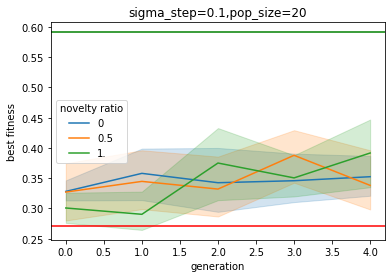

In [49]:
data = pd.DataFrame(data=lines,columns=["generation","best fitness","average fitness","novelty ratio"])
plt.axhline(y=0.59116, color='g', linestyle='-')
plt.axhline(y=0.270718, color='r', linestyle='-')
sns.lineplot(data=data,x="generation",y="best fitness",hue="novelty ratio")
# plt.legend(["Original fitness", "fitness with noise"])
plt.title("sigma_step=0.1,pop_size=20")
plt.show()

In [68]:
#CMAES_step=0.1
#pop_size=100
exp_folder = "/home/leni/are-logs/nipes_pretraining/exploration/191/relearning/s0001_p20_n0/"
lines = []
for folder in os.listdir(exp_folder):
    neval, best_id, best_fit, avg_fit,pop_size = load_all_fitnesses(exp_folder + "/" + folder + "/fitnesses.csv",0)
    gen = range(len(best_fit))
    lines += [[g,bf,af,"0"] for g,bf,af in zip(gen,best_fit,avg_fit)] 
    

In [69]:
#CMAES_step=0.1
#pop_size=100
exp_folder = "/home/leni/are-logs/nipes_pretraining/exploration/191/relearning/s0001_p20_n05/"
for folder in os.listdir(exp_folder):
    neval, best_id, best_fit, avg_fit,pop_size = load_all_fitnesses(exp_folder + "/" + folder + "/fitnesses.csv",0)
    gen = range(len(best_fit))
    lines += [[g,bf,af,"0.5"] for g,bf,af in zip(gen,best_fit,avg_fit)] 
    

In [70]:
#CMAES_step=0.1
#pop_size=100
exp_folder = "/home/leni/are-logs/nipes_pretraining/exploration/191/relearning/s0001_p20_n1/"
for folder in os.listdir(exp_folder):
    neval, best_id, best_fit, avg_fit,pop_size = load_all_fitnesses(exp_folder + "/" + folder + "/fitnesses.csv",0)
    gen = range(len(best_fit))
    lines += [[g,bf,af,"1."] for g,bf,af in zip(gen,best_fit,avg_fit)] 
    

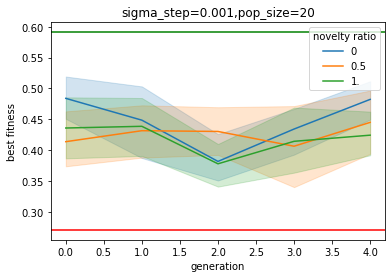

In [71]:
data = pd.DataFrame(data=lines,columns=["generation","best fitness","average fitness","novelty ratio"])
plt.axhline(y=0.59116, color='g', linestyle='-')
plt.axhline(y=0.270718, color='r', linestyle='-')
sns.lineplot(data=data,x="generation",y="best fitness",hue="novelty ratio")
# plt.legend(["Original fitness", "fitness with noise"])
plt.title("sigma_step=0.001,pop_size=20")
plt.show()

In [10]:
traj_ref = load_trajectory("/home/leni/are-logs/nipes_pretraining/exploration/191/nipes_14_8_14-57-56-6050-3172684440/traj_43_69")
traj_noise = load_trajectory("/home/leni/are-logs/visualization_30_8_16-3-31-1171-3302049496/traj_43_0")
trajs=[]

In [11]:

folders = ["s1_p100","s01_p100","s001_p100","s0001_p100"] + ["s10-" + str(i) + "_p100" for i in range(4,11)]
sigma0 = [10**-i for i in range(11)]
lines = []
for dire, s in zip(folders,sigma0):
    print(dire,len(os.listdir(exp_folder + "/" + dire)))
    for folder in os.listdir(exp_folder + "/" + dire):
        neval, best_id, best_fit, avg_fit,pop_size = load_all_fitnesses(exp_folder + "/" + dire + "/" + folder + "/fitnesses.csv",0)
        gen = range(len(best_fit))    
        traj = load_trajectory(exp_folder + "/" + dire + "/" + folder + "/traj_0_" + str(best_id[0]))
        trajs+= [t+[best_id[0],s] for t in traj]
        lines += [[g,bf,af,s] for g,bf,af in zip(gen,best_fit,avg_fit)] 
    trajs += [t+[-1,s] for t in traj_ref]
    trajs += [t+[-2,s] for t in traj_noise]

s1_p100 20
s01_p100 21
s001_p100 20
s0001_p100 30
s10-4_p100 49
s10-5_p100 20
s10-6_p100 20
s10-7_p100 21
s10-8_p100 19
s10-9_p100 19
s10-10_p100 23


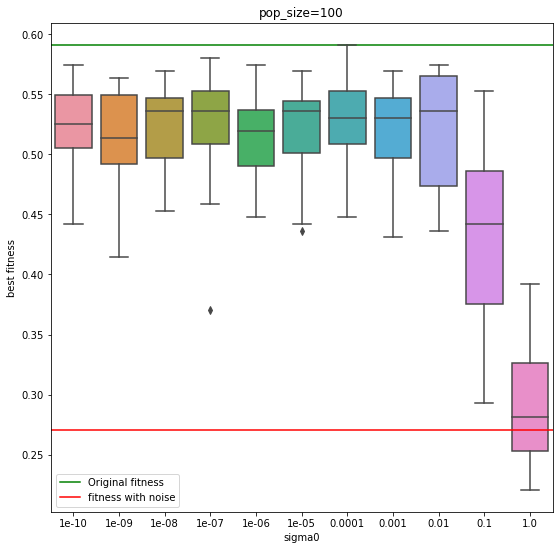

In [12]:
data = pd.DataFrame(data=lines,columns=["generation","best fitness","average fitness","sigma0"])
fig = plt.gcf()
fig.set_size_inches(9, 9)
plt.axhline(y=0.59116, color='g', linestyle='-')
plt.axhline(y=0.270718, color='r', linestyle='-')
sns.boxplot(data=data,x="sigma0",y="best fitness")
plt.legend(["Original fitness", "fitness with noise"])
plt.title("pop_size=100")
plt.show()

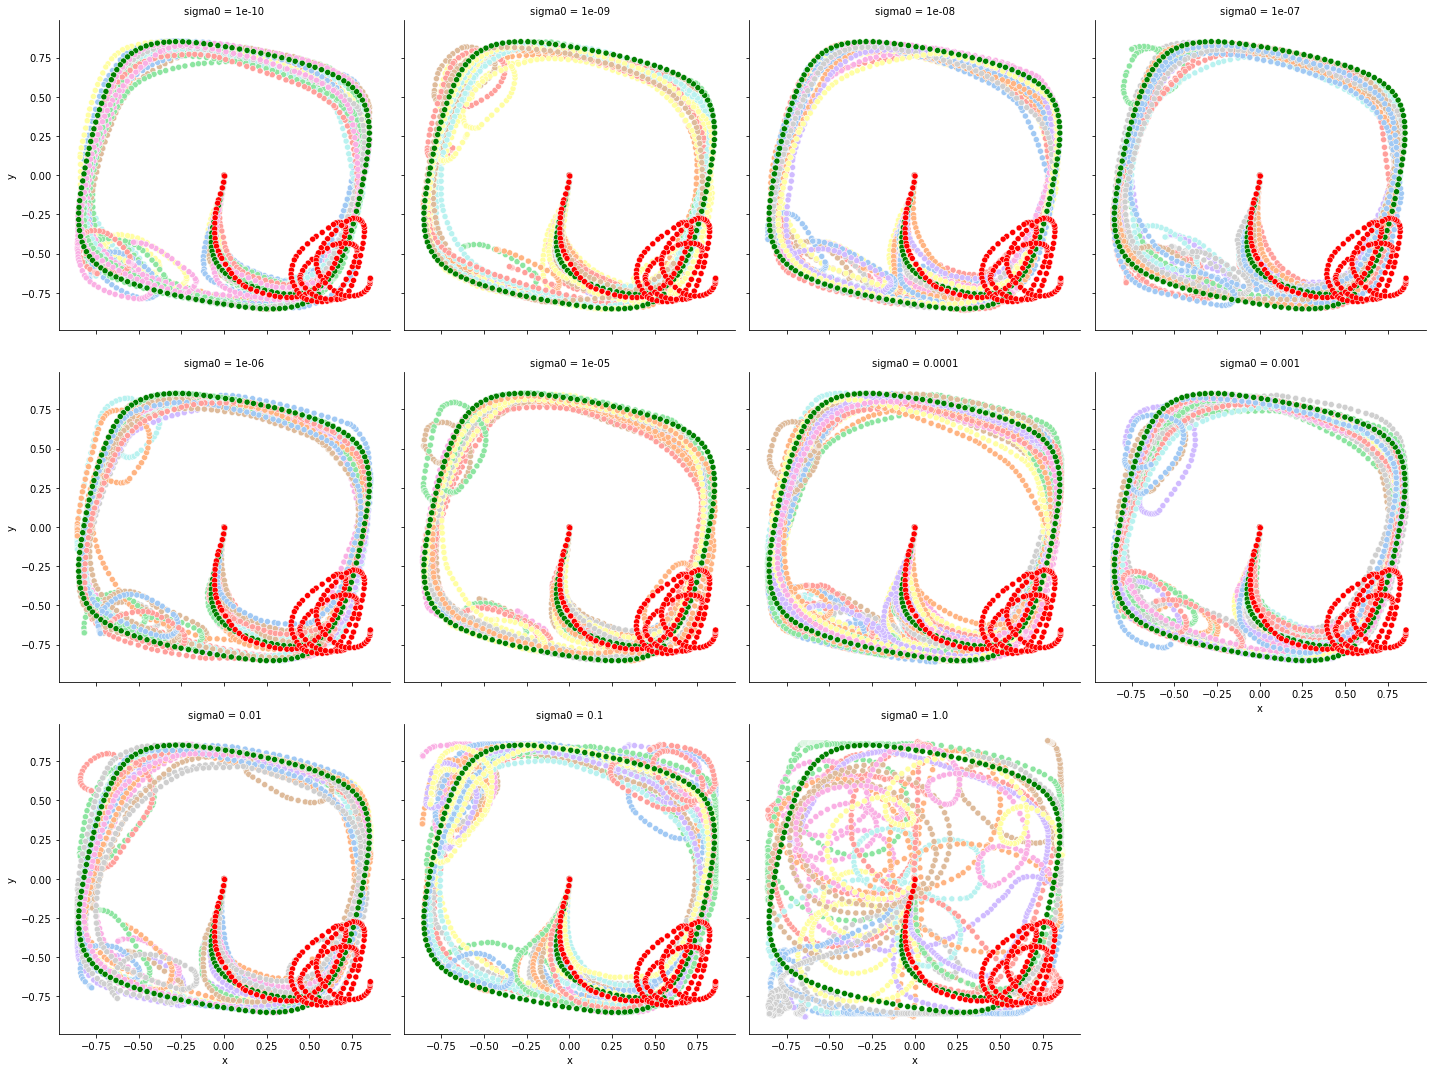

In [13]:
data = pd.DataFrame(data=trajs,columns=["time_step","x","y","z","id","sigma0"])
ids = data["id"].unique()

palette =dict(zip(ids,sns.color_palette("pastel",n_colors=len(ids))))
palette[-1]="green"
palette[-2]="red"
g = sns.relplot(data=data,x="x",y="y",hue="id",col="sigma0",col_wrap=4,legend=False,palette=palette)
# ax.set_xlim([-1,1])
# ax.set_ylim([-1,1])
plt.show()

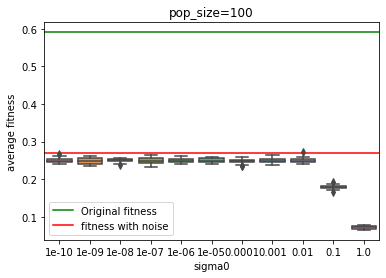

In [594]:
data = pd.DataFrame(data=lines,columns=["generation","best fitness","average fitness","sigma0"])
plt.axhline(y=0.59116, color='g', linestyle='-')
plt.axhline(y=0.270718, color='r', linestyle='-')
sns.boxplot(data=data,x="sigma0",y="average fitness")
plt.legend(["Original fitness", "fitness with noise"])
plt.title("pop_size=100")
plt.show()

In [4]:
traj_ref = load_trajectory("/home/leni/are-logs/nipes_pretraining/exploration/191/nipes_14_8_14-57-56-6050-3172684440/traj_43_69")
traj_noise = load_trajectory("/home/leni/are-logs/visualization_30_8_16-3-31-1171-3302049496/traj_43_0")
trajs=[]
exp_folder = "/home/leni/are-logs/nipes_pretraining/exploration/191/relearning/"

In [5]:

folders = ["s0001_p" + str(i) for i in range(10,110,10)]
pop_size = [i for i in range(10,110,10)]
lines = []
for dire, p in zip(folders,pop_size):
    print(dire,len(os.listdir(exp_folder + "/" + dire)))
    for folder in os.listdir(exp_folder + "/" + dire):
        neval, best_id, best_fit, avg_fit,pop_size = load_all_fitnesses(exp_folder + "/" + dire + "/" + folder + "/fitnesses.csv",0)
        gen = range(len(best_fit))    
        traj = load_trajectory(exp_folder + "/" + dire + "/" + folder + "/traj_0_" + str(best_id[0]))
        trajs+= [t+[best_id[0],p] for t in traj]
        lines += [[g,bf,af,p] for g,bf,af in zip(gen,best_fit,avg_fit)] 
    trajs += [t+[-1,p] for t in traj_ref]
    trajs += [t+[-2,p] for t in traj_noise]

s0001_p10 20
s0001_p20 20
s0001_p30 20
s0001_p40 20
s0001_p50 33


FileNotFoundError: [Errno 2] No such file or directory: '/home/leni/are-logs/nipes_pretraining/exploration/191/relearning//s0001_p50/nipes_27_8_12-10-3-3359-3642355872/fitnesses.csv'

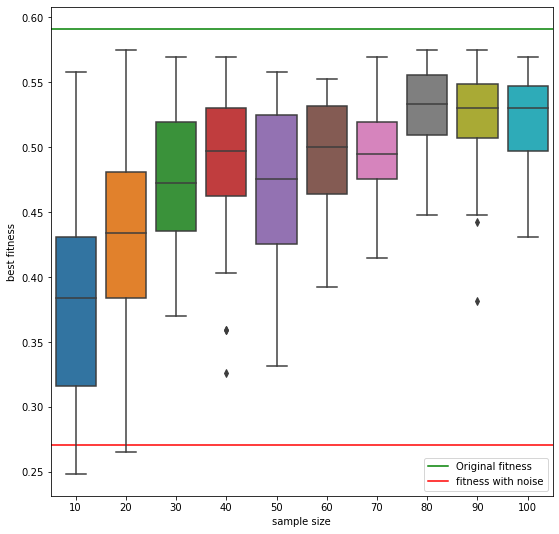

In [576]:
data = pd.DataFrame(data=lines,columns=["generation","best fitness","average fitness","sample size"])
fig = plt.gcf()
fig.set_size_inches(9, 9)
plt.axhline(y=0.59116, color='g', linestyle='-')
plt.axhline(y=0.270718, color='r', linestyle='-')
sns.boxplot(data=data,x="sample size",y="best fitness")
plt.legend(["Original fitness", "fitness with noise"])
plt.show()

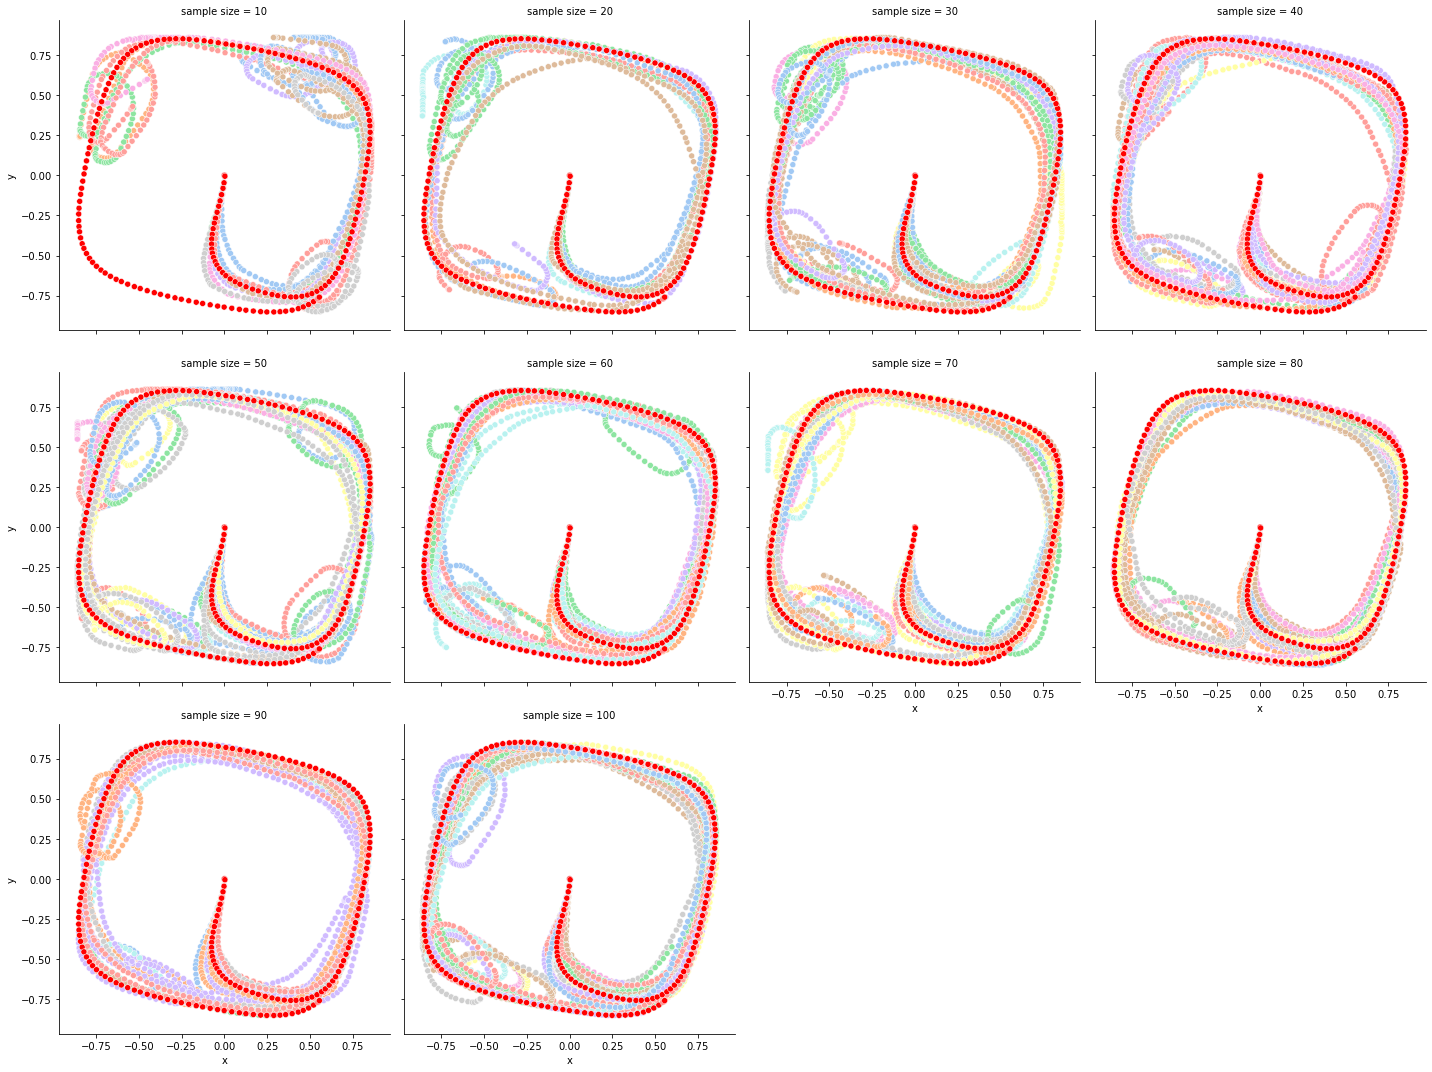

In [577]:
data = pd.DataFrame(data=trajs,columns=["time_step","x","y","z","id","sample size"])
ids = data["id"].unique()

palette =dict(zip(ids,sns.color_palette("pastel",n_colors=len(ids))))
palette[-1]="red"
g = sns.relplot(data=data,x="x",y="y",hue="id",col="sample size",col_wrap=4,legend=False,palette=palette)
# ax.set_xlim([-1,1])
# ax.set_ylim([-1,1])
plt.show()

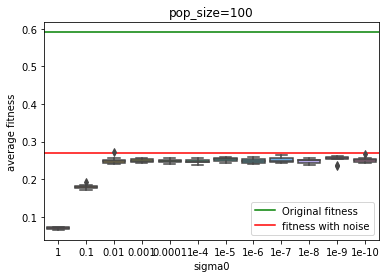

In [494]:
data = pd.DataFrame(data=lines,columns=["generation","best fitness","average fitness","sigma0"])
plt.axhline(y=0.59116, color='g', linestyle='-')
plt.axhline(y=0.270718, color='r', linestyle='-')
sns.boxplot(data=data,x="sigma0",y="average fitness")
plt.legend(["Original fitness", "fitness with noise"])
plt.title("pop_size=100")
plt.show()

[(0, 2, 0.160221), (1, 3, 0.132597), (2, 1, 0.0828729), (3, 1, 0.0883978), (4, 0, 0.104972), (5, 4, 0.127072), (6, 3, 0.0828729), (7, 4, 0.110497), (8, 0, 0.0939227), (9, 2, 0.110497), (10, 4, 0.149171), (11, 0, 0.160221), (12, 0, 0.0939227), (13, 3, 0.348066), (14, 2, 0.116022), (15, 1, 0.127072), (16, 2, 0.110497), (17, 4, 0.187845), (18, 1, 0.0994475), (19, 0, 0.0939227)]


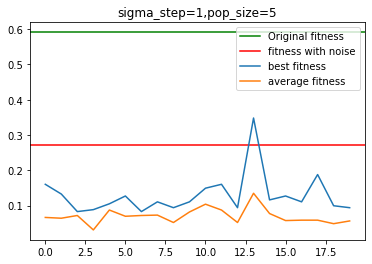

In [30]:
#CMAES_step=1
#pop_size=5
exp_folder = "/home/le_goff/are-logs/nipes_pretraining/exploration/191/relearning/nipes_23_8_14-4-24-4110-406488301/"
neval, best_id, best_fit, avg_fit,pop_size = load_all_fitnesses(exp_folder + "/fitnesses.csv",0)
gen = range(len(best_fit))
fit_id = [(g,i,fit) for g,i,fit in zip(gen,best_id,best_fit)]

print(fit_id)
plt.axhline(y=0.59116, color='g', linestyle='-')
plt.axhline(y=0.270718, color='r', linestyle='-')
plt.plot(gen,best_fit,avg_fit)
plt.legend(["Original fitness", "fitness with noise", "best fitness","average fitness"])
plt.title("sigma_step=1,pop_size=5")
plt.show()

[(0, 7, 0.116022), (1, 1, 0.41989), (2, 6, 0.20442), (3, 7, 0.226519), (4, 9, 0.176796), (5, 4, 0.143646), (6, 2, 0.370166), (7, 5, 0.325967), (8, 6, 0.21547), (9, 9, 0.209945)]


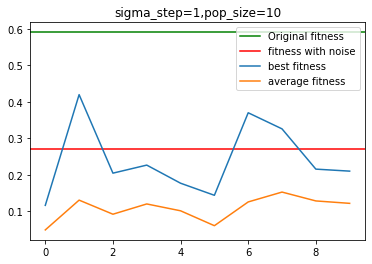

In [31]:
#CMAES_step=1
#pop_size=10
exp_folder = "/home/le_goff/are-logs/nipes_pretraining/exploration/191/relearning/nipes_23_8_15-33-8-8265-795795502/"
neval, best_id, best_fit, avg_fit,pop_size = load_all_fitnesses(exp_folder + "/fitnesses.csv",0)
gen = range(len(best_fit))
fit_id = [(g,i,fit) for g,i,fit in zip(gen,best_id,best_fit)]

print(fit_id)
plt.axhline(y=0.59116, color='g', linestyle='-')
plt.axhline(y=0.270718, color='r', linestyle='-')
plt.plot(gen,best_fit,avg_fit)
plt.title("sigma_step=1,pop_size=10")
plt.legend(["Original fitness", "fitness with noise", "best fitness","average fitness"])
plt.show()

In [17]:
traj_ref = load_trajectory("/home/leni/are-logs/nipes_pretraining/exploration/9_184/nipes_21_8_11-18-41-1718-1638057784/traj_54_3")
traj_noise = load_trajectory("/home/leni/are-logs/visualization_28_8_10-37-41-1659-4022849345/traj_54_0")
trajs=[]
exp_folder = "/home/leni/are-logs/nipes_pretraining/exploration/9_184/relearning/"

(-1, 1)

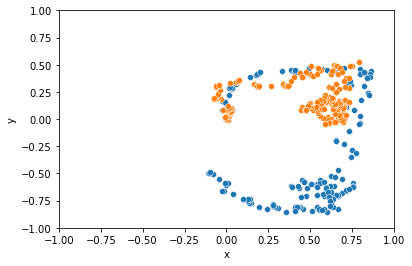

In [18]:
data_ref = pd.DataFrame(data=traj_ref,columns=["time step","x","y","z"])
data_noise = pd.DataFrame(data=traj_noise,columns=["time step","x","y","z"])
sns.scatterplot(data=data_ref,x="x",y="y")
ax = sns.scatterplot(data=data_noise,x="x",y="y")
ax.set_xlim([-1,1])
ax.set_ylim([-1,1])

In [19]:

folders = ["s1_p100","s01_p100","s001_p100","s0001_p100"] + ["s1e-" + str(i) + "_p100" for i in range(4,11)]
sigma0 = [10**-i for i in range(11)]
lines = []
for dire, s in zip(folders,sigma0):
    print(dire,len(os.listdir(exp_folder + "/" + dire)))
    for folder in os.listdir(exp_folder + "/" + dire):
        neval, best_id, best_fit, avg_fit,pop_size = load_all_fitnesses(exp_folder + "/" + dire + "/" + folder + "/fitnesses.csv",0)
        gen = range(len(best_fit))    
        traj = load_trajectory(exp_folder + "/" + dire + "/" + folder + "/traj_0_" + str(best_id[0]))
        trajs+= [t+[best_id[0],s] for t in traj]
        lines += [[g,bf,af,s] for g,bf,af in zip(gen,best_fit,avg_fit)] 
    trajs += [t+[-1,s] for t in traj_ref]
    trajs += [t+[-2,s] for t in traj_noise]

s1_p100 20
s01_p100 20
s001_p100 28
s0001_p100 32
s1e-4_p100 31
s1e-5_p100 28
s1e-6_p100 31
s1e-7_p100 27
s1e-8_p100 20
s1e-9_p100 23
s1e-10_p100 20


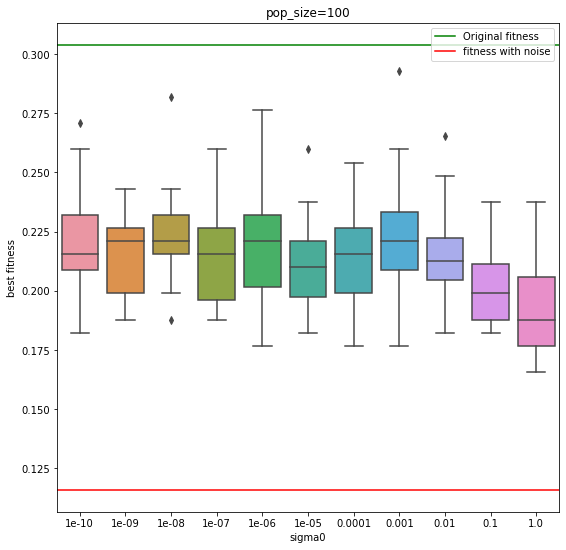

In [20]:
data = pd.DataFrame(data=lines,columns=["generation","best fitness","average fitness","sigma0"])
fig = plt.gcf()
fig.set_size_inches(9, 9)
plt.axhline(y=0.303867, color='g', linestyle='-')
plt.axhline(y=0.116022, color='r', linestyle='-')
sns.boxplot(data=data,x="sigma0",y="best fitness")
plt.legend(["Original fitness", "fitness with noise"])
plt.title("pop_size=100")
plt.show()

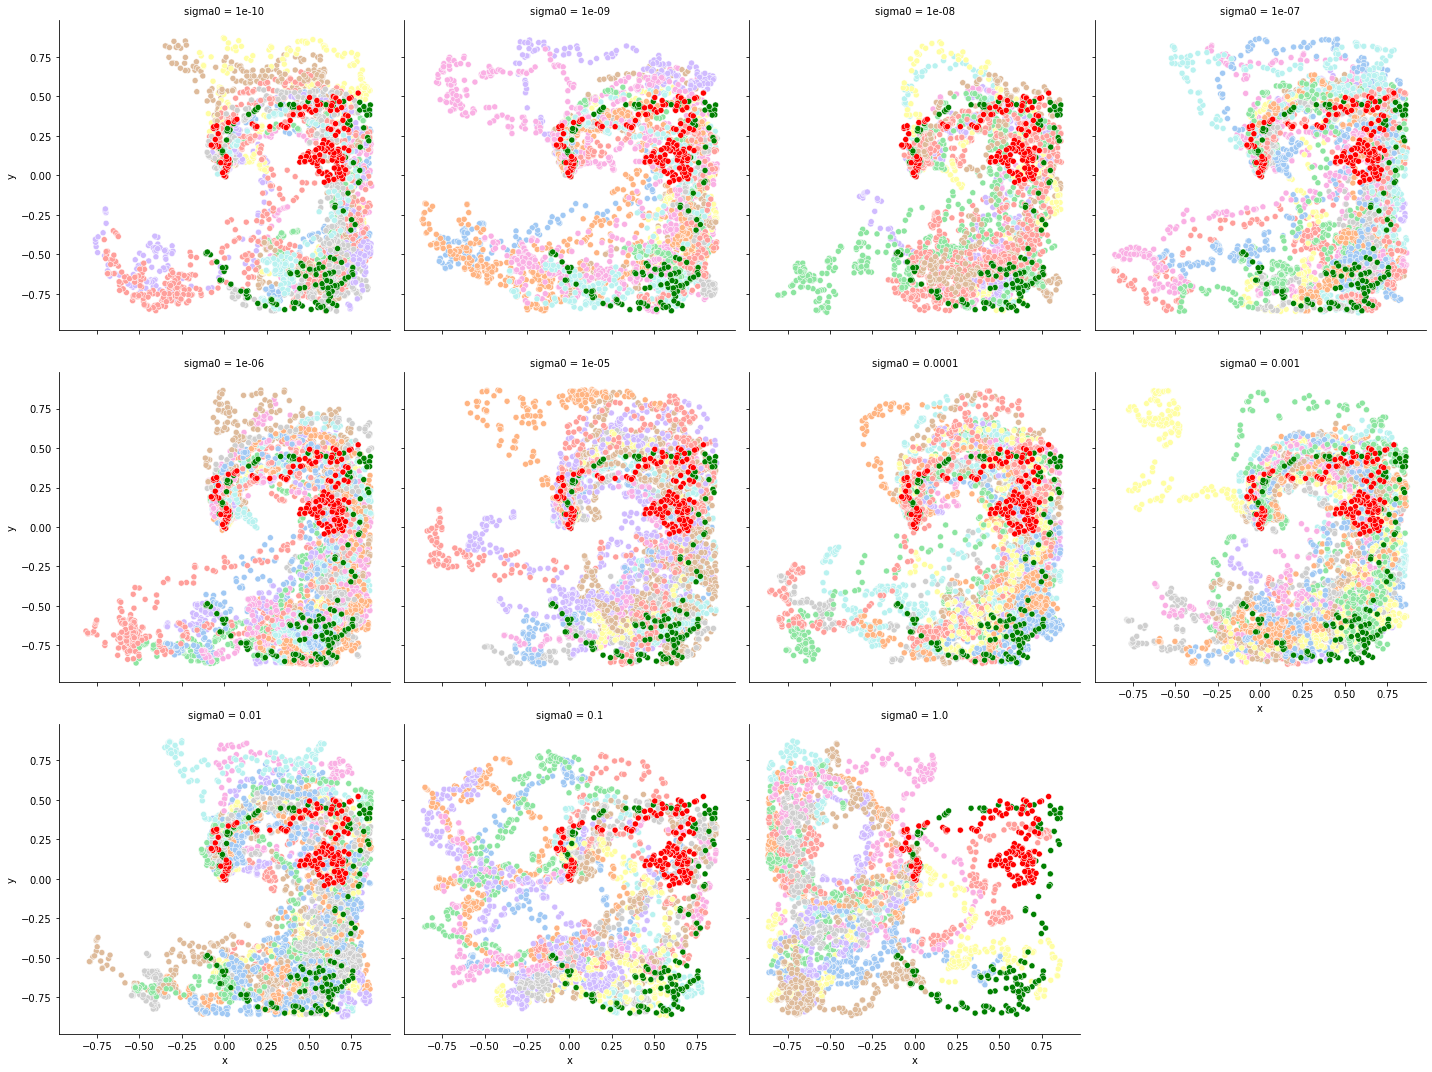

In [21]:
data = pd.DataFrame(data=trajs,columns=["time_step","x","y","z","id","sigma0"])
ids = data["id"].unique()

palette =dict(zip(ids,sns.color_palette("pastel",n_colors=len(ids))))
palette[-1]="green"
palette[-2]="red"
g = sns.relplot(data=data,x="x",y="y",hue="id",col="sigma0",col_wrap=4,legend=False,palette=palette)
# ax.set_xlim([-1,1])
# ax.set_ylim([-1,1])
plt.show()

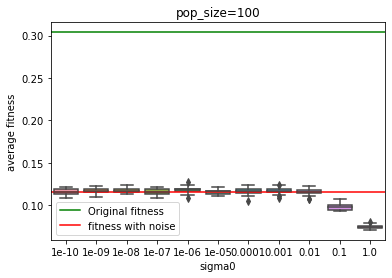

In [16]:
data = pd.DataFrame(data=lines,columns=["generation","best fitness","average fitness","sigma0"])
plt.axhline(y=0.303867, color='g', linestyle='-')
plt.axhline(y=0.116022, color='r', linestyle='-')
sns.boxplot(data=data,x="sigma0",y="average fitness")
plt.legend(["Original fitness", "fitness with noise"])
plt.title("pop_size=100")
plt.show()